## This is the solution file by RaghuNath for the Lane detection project


In [1]:
#importing the packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline


In [2]:


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def plotmyimage(img,title=''):
    plt.imshow(img,cmap='gray') # draws in grayscale if it is M x N x 1, draws in color if RGB
    plt.title(title)
    plt.show()
    
def find_lineslopes(lines):
    slopes=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slopes.append((y2-y1)/(x2-x1))
    slopes=np.array(slopes)
    return slopes


In [3]:
from moviepy.editor import *
from IPython.display import HTML


In [4]:
def process_image(image):
    global leftslope
    global rightslope
    global init
    global leftcurve
    global rightcurve
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    tmpimage=np.copy(image)*0
    imshape=image.shape
    #plotmyimage(image,'original image')        
    
    vThreshold=int(imshape[0]*0.6)
    hThresholdl=int(imshape[1]*0.48)
    #hThresholdc=int(imshape[1]*0.515)
    hThresholdr=int(imshape[1]*0.57)
    # defining boundaries of the polygon to mask rest of the region
    vertices = np.array([[(0.1*imshape[1], imshape[0]*0.92), (hThresholdl, vThreshold), (hThresholdr, vThreshold), (imshape[1]*0.9, imshape[0]*0.92)]], dtype=np.int32)



    gray=grayscale(image)
    #plotmyimage(gray,'gray image')

    gray_gauss=gaussian_blur(gray,3)
    #plotmyimage(gray_gauss,'gauss filtered')

    maskedgray=(region_of_interest(gray,vertices))
    avgintensity=np.mean(maskedgray[maskedgray>0])
    avgintensity=255-avgintensity;
    gray_gauss_canny=canny(gray_gauss,max(avgintensity*0.4,0),min(avgintensity*0.8,255))
    #plotmyimage(gray_gauss_canny,'canny edge detected')
    #print(avgintensity)
    


    canny_masked=region_of_interest(gray_gauss_canny,vertices)
    #plotmyimage(region_of_interest(image,vertices),'masked image')
    #plotmyimage(canny_masked,'masked canny edge detected')

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = imshape[0]*0.05   # minimum number of pixels making up a line
    max_line_gap = imshape[0]*0.04    # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(canny_masked, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    line_image=hough_lines(canny_masked,rho,theta,threshold,min_line_length,max_line_gap)
    slopes=find_lineslopes(lines)
    
    #plotmyimage(line_image,'line image output')
    
    #print(slopes)
    #pdb.set_trace()
    xcoordinates1=lines[:,:,0]
    xcoordinates2=lines[:,:,2]
    ycoordinates1=lines[:,:,1]
    ycoordinates2=lines[:,:,3]
    
    if leftslope==0:
        slopeThresholdLUpper=-0.3
        slopeThresholdLLower=-10
    else:
        slopeThresholdLUpper=leftslope*0.8
        slopeThresholdLLower=leftslope*1.2
        
    if rightslope==0:
        slopeThresholdRUpper=10
        slopeThresholdRLower=0.3
    else:
        slopeThresholdRUpper=rightslope*1.2
        slopeThresholdRLower=rightslope*0.8
        
    #print(np.logical_and(slopes<0 ,np.logical_and(xcoordinates1[:,0]<hThresholdr,xcoordinates2[:,0]<hThresholdr)))
    #print(slopes[np.logical_and(np.logical_and(slopes<-0.1,slopes>-20) ,np.logical_and(xcoordinates1[:,0]<hThresholdr,xcoordinates2[:,0]<hThresholdr))])
    slopeThresholdleft= np.mean(slopes[np.logical_and(np.logical_and(slopes<slopeThresholdLUpper,slopes>slopeThresholdLLower) ,np.logical_and(xcoordinates1[:,0]<hThresholdr,xcoordinates2[:,0]<hThresholdr))])
    slopeThresholdright=np.mean(slopes[np.logical_and(np.logical_and(slopes> slopeThresholdRLower,slopes< slopeThresholdRUpper) ,np.logical_and(xcoordinates1[:,0]>hThresholdl,xcoordinates2[:,0]>hThresholdl))])

    #slopeThresholdleft=np.mean(slopes[])
    #print(slopes)
    #print(slopeThresholdleft)
    #print(slopeThresholdright)
    
    pickleft1=np.logical_and(np.logical_and(slopes<slopeThresholdleft*0.8,slopes>slopeThresholdleft*2) ,  np.logical_and(xcoordinates1[:,0]<hThresholdr,xcoordinates2[:,0]<hThresholdr))
    pickright1=np.logical_and(np.logical_and(slopes>slopeThresholdright*0.8,slopes<slopeThresholdright*2) ,np.logical_and(xcoordinates1[:,0]>hThresholdl,xcoordinates2[:,0]>hThresholdl))

    
    xcoordinatesleft=np.append(xcoordinates1[pickleft1], xcoordinates2[pickleft1]) 
    ycoordinatesleft=np.append(ycoordinates1[pickleft1], ycoordinates2[pickleft1]) 
    
    xcoordinatesright=np.append(xcoordinates1[pickright1], xcoordinates2[pickright1])
    ycoordinatesright=np.append(ycoordinates1[pickright1], ycoordinates2[pickright1])


    #identified the left and right lines' y coordinates based on their slopes
    
#    print('printing the slopes, slope thresholds and coordinates')
#    print(slopes)
#    print('slope threshold left')
#    print(slopeThresholdleft)
#    print('slope threshold right')
#    print(slopeThresholdright)
#    print('all x coordinates')
#    print(xcoordinates1)
#    print('all y coordinates')
#    print(ycoordinates1)
#    print('filtered coordinates x left')
#    print(xcoordinatesleft)
#    print('filtered coordinates y left')
#    print(ycoordinatesleft)
#    print('filtered coordinates x right')
#    print(xcoordinatesright)
#    print('filtered coordinates y right')
#    print(ycoordinatesright)
#    
    #plt.imshow(image)
    #print(ycoordinatesleft)
    #print(ycoordinatesright)
    if len(ycoordinatesleft)>0 and len(ycoordinatesright):
        pfleft_inv=np.polyfit(ycoordinatesleft,xcoordinatesleft,1)
        pfright_inv=np.polyfit(ycoordinatesright,xcoordinatesright,1)
        
        leftslope=1/pfleft_inv[0]
        
        rightslope= 1/pfright_inv[0]
        
        
       
        
        fleft_inv=np.poly1d(pfleft_inv)
        fright_inv=np.poly1d(pfright_inv)
        #vLimit=max(min(ycoordinatesleft),min(ycoordinatesright))
        vLimit=min(np.append(ycoordinatesleft,ycoordinatesright))
    else:
        init=-1
    
    if init==1:
        init=0
        leftcurve=fleft_inv
        rightcurve=fright_inv
    elif init==-1: #blind mode. using past values
        fleft_inv=leftcurve
        fright_inv=rightcurve
        init=0
        vLimit=vThreshold
    else:
        fleft_inv=fleft_inv*0.1 + 0.9*leftcurve
        fright_inv=fright_inv*0.1 + 0.9*rightcurve
        leftcurve=fleft_inv
        rightcurve=fright_inv


    vLimit=vThreshold
    
    
    
    

    # defined the functions that give x coordinate given a y coordinate. inv in the title only indicates that the function returns x coordinate
    mylines=[[[int(fleft_inv(imshape[0])),imshape[0],int(fleft_inv(vLimit)),vLimit ],[int(fright_inv(imshape[0])),imshape[0],int(fright_inv(vLimit)),vLimit ]]]
    #identified the lines to be drawn
    
    draw_lines(tmpimage,mylines,thickness=5)
    
    result=weighted_img(image,tmpimage)
    #plotmyimage(result,'result')
    return result

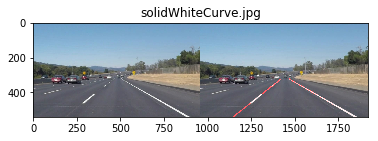

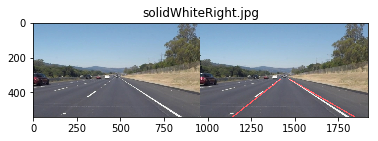

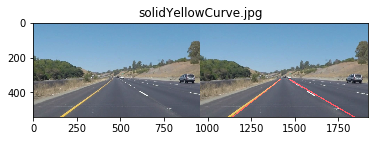

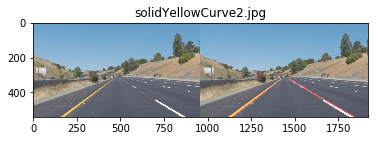

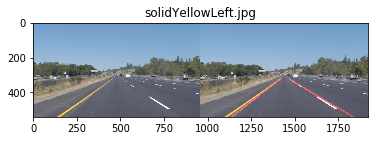

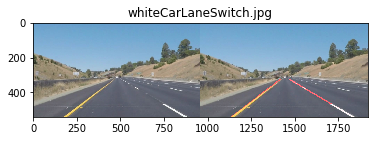

In [5]:
myfiles=os.listdir("test_images/")
leftslope=0
rightslope=0
init=1;
leftcurve=np.poly1d([0,0])
rightcurve=leftcurve
for file in myfiles:
    image = mpimg.imread('test_images/'+file)
    result=process_image(image)
    plotmyimage(np.hstack((image,result)),file)

In [6]:
file='challenge.mp4'
white_output = 'test_videos_output/'+file
leftslope=0
rightslope=0
init=1;
leftcurve=np.poly1d([0,0])
rightcurve=leftcurve
clip1 = VideoFileClip("test_videos/"+file)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:52<00:00,  5.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 58.9 s


In [8]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(white_output))
    